# Imports

In [12]:
import logging
import numpy as np
import pandas as pd
import stumpy
from src import common, pipeline
from src.outlier_model import OutlierModel
import pickle5 as pickle
import matplotlib.pyplot as plt


logging.basicConfig(format='%(asctime)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger("TimeSeries")
logger.setLevel(logging.INFO)

# Dataset preprocessing

In [13]:
column_types_loc = "#datasets/Colab_PowerConverter/column_types.json"
column_types = common.json_load(column_types_loc)

target = column_types["target"]
identifier = column_types["identifier"]
cat_cols = column_types["categorical"]
measurement_label = column_types["measurement_label"]

with open(f"#datasets/Colab_PowerConverter/dataset.pkl", "rb") as fh:
  data = pickle.load(fh)

# this measurement did not have a fault (?)
data = data[data[measurement_label]!="Single-Phase_Sensor_Fault"]
data.reset_index(inplace=True, drop=True)

# assign unique label to each measurement fault and create dictionary for easier analysis
fault_dict = {}
for label,i in zip(data[measurement_label].unique(), range(len(data[measurement_label].unique()))):
    data.loc[(data[measurement_label]==label) & (data[target]==1), target] = int(i+1)
    fault_dict[label] = int(i+1)

data.drop(columns=[measurement_label], inplace=True)
# Fill NA - 0 for numerical and 'NA' for categorical
# categorical
data[cat_cols] = data[cat_cols].fillna("NA")
data[cat_cols] = data[cat_cols].astype(str)
# non-categorical
non_cat_cols = data.drop(columns=cat_cols + [identifier]).columns.tolist()
data[non_cat_cols] = data[non_cat_cols].fillna(0)


# Train model

In [14]:
task = "multiclass"

column_types_loc = "#datasets/Colab_PowerConverter/column_types.json"
save_loc = "models.dill"

parameters = {
    "random_state": 1,
    "test_size_train": 0.2,
    "test_size_valid": 0.5,
    "scaler": "Standard",
}


In [15]:
# (
#     data_train_scaled,
#     data_valid_scaled,
#     data_test_scaled,
#     models,
# ) = pipeline.train(task,data, column_types_loc, parameters, save_loc=save_loc, verbose=True, datasets=True)


In [16]:
# predicted = pipeline.predict(data, column_types_loc, save_loc)

# Outlier_model
* outlier_model code that implementes outlier_model.predict() function

In [17]:
start_index = 0
end_index = 1000000
data_test = data[start_index:end_index]

outlier_key = "f_c"
m = 250
preload_size = 5000
# plt.plot(data[40750:41250][outlier_key])
outlier_model = OutlierModel(m=m,std_dev=5,
                             time_series=data_test[:preload_size][outlier_key],
                             egress=True)


# Simulate stream of data
## Inverse transform test dataset for evaluation

In [18]:

# data_test = pd.DataFrame(models["scaler"].inverse_transform(data_test_scaled.drop(columns=cat_cols + [identifier,target])),
#                columns=data_test_scaled.drop(columns=cat_cols + [identifier,target]).columns.values)
# data_test[[identifier,target]] = data_test_scaled[[identifier,target]].copy()

In [19]:
data_test.head()

,f_c,P,m_d,m_q,theta,P_ref,V_DC,V_phaseA,V_phaseB,V_phaseC,I_phaseA,I_phaseB,I_phaseC,fault,sample_id
0,0.160401,102708.459241,311.0,0.0,-163.738242,2500.0,800.0,-259.299072,-19.057368,278.356440,294.335345,-928.391542,634.056197,0,0
1,0.267618,102492.887801,311.0,0.0,-163.738192,2500.0,800.0,-259.696384,-18.337809,278.034193,284.639238,-916.942492,632.303254,0,1
2,0.369417,102288.207648,311.0,0.0,-163.738108,2500.0,800.0,-260.114450,-17.577815,277.692264,274.799672,-905.428051,630.628379,0,2
3,0.465867,102094.284312,311.0,0.0,-163.737992,2500.0,800.0,-260.553771,-16.775993,277.329764,264.816484,-893.849302,629.032819,0,3
4,0.557028,101910.993770,311.0,0.0,-163.737845,2500.0,800.0,-261.014849,-15.930912,276.945761,254.689537,-882.207299,627.517762,0,4


* loading the whole DL model with preprocessors in each iteration is stupid but I wanted to send Alex at least some initial code


In [20]:
fault = False
for index, row in data_test[preload_size:].iterrows():
    outlier_model.train_one(row[outlier_key])
    fault = outlier_model.predict_one(index)
    if index % 10000 == 0:
        print(f"Current Global index: {index}")
    # if not fault:
    #     print("fault start")
    # else:
        # predicted = pipeline.predict(row, column_types_loc, save_loc)
        # print("fault continues")
        # if predicted == 0:
        #     fault = False
        #     print("fault ended")

01/25/2022 06:57:08 PM:  Anomaly at Global index: 6140
01/25/2022 06:57:08 PM: max_mp: 7.2201, metric:7.2079: metric-max_mp: 0.012199999999999989


Current Global index: 10000


01/25/2022 06:57:12 PM:  Anomaly at Global index: 16140
01/25/2022 06:57:12 PM: max_mp: 8.7234, metric:8.415099999999999: metric-max_mp: 0.3083000000000009


Current Global index: 20000


01/25/2022 06:57:15 PM:  Anomaly at Global index: 26140
01/25/2022 06:57:15 PM: max_mp: 5.9399, metric:4.1901: metric-max_mp: 1.7497999999999996


Current Global index: 30000


01/25/2022 06:57:19 PM:  Anomaly at Global index: 36140
01/25/2022 06:57:19 PM: max_mp: 13.7448, metric:13.0764: metric-max_mp: 0.6684000000000001


Current Global index: 40000


01/25/2022 06:57:22 PM:  Anomaly at Global index: 46140
01/25/2022 06:57:22 PM: max_mp: 30.8707, metric:16.8686: metric-max_mp: 14.002099999999999


Current Global index: 50000


01/25/2022 06:57:27 PM:  Anomaly at Global index: 58706
01/25/2022 06:57:27 PM: max_mp: 3.3937, metric:3.3813999999999997: metric-max_mp: 0.0123000000000002


Current Global index: 60000


01/25/2022 06:57:31 PM:  Anomaly at Global index: 69424
01/25/2022 06:57:31 PM: max_mp: 5.6402, metric:5.6244: metric-max_mp: 0.01580000000000048


Current Global index: 70000


01/25/2022 06:57:34 PM:  Anomaly at Global index: 80001
01/25/2022 06:57:34 PM: max_mp: 73.3401, metric:8.5336: metric-max_mp: 64.8065


Current Global index: 80000
Current Global index: 90000
Current Global index: 100000
Current Global index: 110000


01/25/2022 06:57:49 PM:  Anomaly at Global index: 120009
01/25/2022 06:57:49 PM: max_mp: 0.0151, metric:0.001: metric-max_mp: 0.014100000000000001


Current Global index: 120000
Current Global index: 130000
Current Global index: 140000
Current Global index: 150000
Current Global index: 160000
Current Global index: 170000
Current Global index: 180000
Current Global index: 190000


01/25/2022 06:58:19 PM:  Anomaly at Global index: 200016
01/25/2022 06:58:19 PM: max_mp: 0.0239, metric:0.002: metric-max_mp: 0.021900000000000003


Current Global index: 200000
Current Global index: 210000
Current Global index: 220000
Current Global index: 230000
Current Global index: 240000
Current Global index: 250000
Current Global index: 260000
Current Global index: 270000


01/25/2022 06:58:50 PM:  Anomaly at Global index: 280344
01/25/2022 06:58:50 PM: max_mp: 1689.7735, metric:122.91919999999999: metric-max_mp: 1566.8543


Current Global index: 280000
Current Global index: 290000
Current Global index: 300000
Current Global index: 310000
Current Global index: 320000
Current Global index: 330000
Current Global index: 340000
Current Global index: 350000


01/25/2022 06:59:19 PM:  Anomaly at Global index: 360041
01/25/2022 06:59:19 PM: max_mp: 0.1243, metric:0.009: metric-max_mp: 0.1153


Current Global index: 360000
Current Global index: 370000
Current Global index: 380000
Current Global index: 390000


01/25/2022 06:59:34 PM:  Anomaly at Global index: 400056
01/25/2022 06:59:34 PM: max_mp: 0.113, metric:0.008: metric-max_mp: 0.10500000000000001


Current Global index: 400000
Current Global index: 410000
Current Global index: 420000
Current Global index: 430000


01/25/2022 06:59:47 PM:  Anomaly at Global index: 440067
01/25/2022 06:59:47 PM: max_mp: 0.0129, metric:0.001: metric-max_mp: 0.0119


Current Global index: 440000
Current Global index: 450000
Current Global index: 460000
Current Global index: 470000
Current Global index: 480000
Current Global index: 490000
Current Global index: 500000
Current Global index: 510000


01/25/2022 07:00:13 PM:  Anomaly at Global index: 520068
01/25/2022 07:00:13 PM: max_mp: 0.0395, metric:0.0029999999999999996: metric-max_mp: 0.0365


Current Global index: 520000
Current Global index: 530000
Current Global index: 540000
Current Global index: 550000
Current Global index: 560000
Current Global index: 570000
Current Global index: 580000
Current Global index: 590000


01/25/2022 07:00:40 PM:  Anomaly at Global index: 600093
01/25/2022 07:00:40 PM: max_mp: 0.0478, metric:0.0035: metric-max_mp: 0.0443


Current Global index: 600000
Current Global index: 610000
Current Global index: 620000
Current Global index: 630000
Current Global index: 640000
Current Global index: 650000
Current Global index: 660000
Current Global index: 670000


01/25/2022 07:01:06 PM:  Anomaly at Global index: 680070
01/25/2022 07:01:06 PM: max_mp: 0.0262, metric:0.002: metric-max_mp: 0.0242


Current Global index: 680000
Current Global index: 690000
Current Global index: 700000
Current Global index: 710000
Current Global index: 720000
Current Global index: 730000
Current Global index: 740000
Current Global index: 750000


01/25/2022 07:01:34 PM:  Anomaly at Global index: 760111
01/25/2022 07:01:34 PM: max_mp: 0.0146, metric:0.001: metric-max_mp: 0.013600000000000001


Current Global index: 760000
Current Global index: 770000
Current Global index: 780000
Current Global index: 790000
Current Global index: 800000
Current Global index: 810000
Current Global index: 820000
Current Global index: 830000


01/25/2022 07:02:01 PM:  Anomaly at Global index: 840106
01/25/2022 07:02:01 PM: max_mp: 0.0112, metric:0.001: metric-max_mp: 0.0102


Current Global index: 840000
Current Global index: 850000
Current Global index: 860000
Current Global index: 870000


01/25/2022 07:02:14 PM:  Anomaly at Global index: 880062
01/25/2022 07:02:14 PM: max_mp: 1.6339, metric:0.11879999999999999: metric-max_mp: 1.5151


Current Global index: 880000
Current Global index: 890000
Current Global index: 900000
Current Global index: 910000


01/25/2022 07:02:28 PM:  Anomaly at Global index: 920403
01/25/2022 07:02:28 PM: max_mp: 7215.7619, metric:524.8948: metric-max_mp: 6690.8671


Current Global index: 920000
Current Global index: 930000
Current Global index: 940000
Current Global index: 950000


01/25/2022 07:02:42 PM:  Anomaly at Global index: 960063
01/25/2022 07:02:42 PM: max_mp: 0.0772, metric:0.0055000000000000005: metric-max_mp: 0.0717


Current Global index: 960000
Current Global index: 970000
Current Global index: 980000
Current Global index: 990000


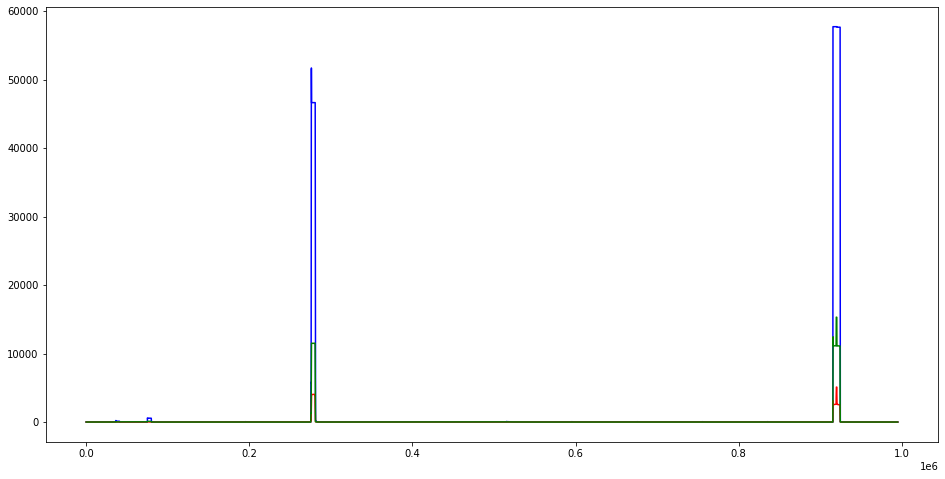

In [21]:
plt.figure(figsize=(16,8))

plt.plot(outlier_model.max_val,'b-',
         outlier_model.max_mean,'r-',
         outlier_model.max_std_dev,'g-')


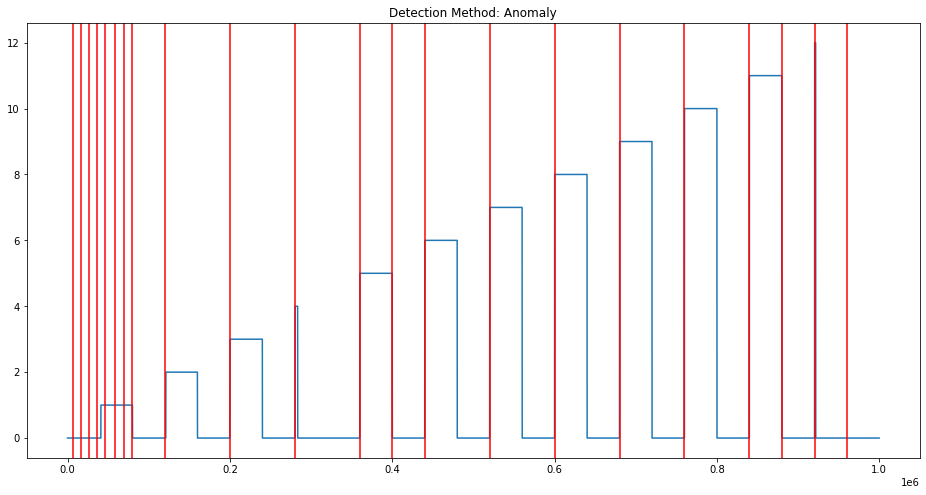

In [22]:
plt.figure(figsize=(16,8))
plt.plot(data_test["fault"])
plt.title(f"Detection Method: Anomaly")
for i in outlier_model.anomalies:
    plt.axvline(x=i,color='r')